In [1]:
import re
import requests
from bs4 import BeautifulSoup

In [2]:
def get_content(url):
    response = requests.get(url)
    assert response.status_code == 200
    
    return response.text

In [3]:
## print out plot,
wiki = 'https://en.wikipedia.org/wiki/The_Gift_of_the_Magi'
soup = BeautifulSoup(get_content(wiki))

elements = soup.find("span", {"id": 'Plot'}).parent.parent.find_all(['p','h2'])

take_plot = False
plot = []
for element in elements:
    if take_plot and element.name == 'p':
        plot.append(element.text)
    
    if element.find("span", {"id": 'Plot'}):
        take_plot = True
    
print('\n'.join(plot))

On Christmas Eve, with only one day left to find a Christmas gift for her husband James Dillingham Young, Della sells her hair for $20 to a nearby hairdresser named Madame Sofronie. She eventually finds a platinum pocket watch chain for Jim's watch for $21 and was satisfied that she found the perfect gift for Jim. 

Later that night Della admits to Jim that she sold her hair to buy him his present. Jim gives Della her present – a set of combs, useless now that her hair is shortened. Della then shows Jim the chain she bought for him, to which Jim says he sold his watch to get the money to buy her ornamental combs. Although Jim and Della are now left with gifts that neither one can use, they realize how far they are willing to go to show their love for each other, and how priceless their love really is. 

The story ends with the narrator comparing the sacrificial gifts of love with those of the Biblical Magi.



In [4]:
url = 'http://www.gutenberg.org/cache/epub/7256/pg7256.txt'
content = get_content(url)

In [5]:
def clean_gift_of_the_magi(content):
    start_of_ebook = '*** START OF THIS PROJECT GUTENBERG EBOOK THE GIFT OF THE MAGI ***'
    end_of_ebook = 'End of the Project Gutenberg EBook of The Gift of the Magi, by O. Henry'
    
    start_of_ebook_index = content.index(start_of_ebook) + len(start_of_ebook)
    end_of_ebook_index = content.index(end_of_ebook)

    text = content[start_of_ebook_index:end_of_ebook_index]

    start_of_author = 'by O. Henry'
    start_of_author_index = text.index(start_of_author) + len(start_of_author)
    
    text = text[start_of_author_index:]
    
    return re.sub(r'[\r\n]+', ' ', text, flags=re.MULTILINE).strip()

text = clean_gift_of_the_magi(content)

In [6]:
import spacy
from collections import defaultdict

In [7]:
nlp = spacy.load('en_core_web_md')

In [8]:
doc = nlp(text)

In [10]:
plus_or_minus_limit = 75

characters = defaultdict(int)
for ent in doc.ents:
    
    if ent.label_ == 'PERSON':
        person = ent.text.strip()
        person_lower = person.lower()
        if not 'mme' in person_lower:
            characters[person] += 1

In [11]:
characters

defaultdict(int,
            {'Della': 18,
             'James Dillingham Young': 2,
             'Jim': 26,
             'Sheba': 1,
             'Solomon': 1,
             'Sofronie': 2,
             'Madame': 3,
             'Babe': 1})

In [12]:
from afinn import Afinn

In [14]:
interactions = []

afinn = Afinn('en')

tokens = doc
for index, token in enumerate(tokens):
    if characters[token.text] > 0:
        start = index - 15
        end = index + 15
        
        close_to = tokens[start:end]
        for close in close_to:
            if close.text != token.text and characters[close.text] > 0:
                sentence = ' '.join([ tk.text for tk in close_to ])
                interactions.append(
                    (token.text, close.text, afinn.score(sentence))
                )

In [15]:
interactions

[('Della', 'Sheba', 0.0),
 ('Sheba', 'Della', 0.0),
 ('Sheba', 'Della', 0.0),
 ('Della', 'Sheba', 0.0),
 ('Jim', 'Solomon', 2.0),
 ('Sofronie', 'Della', -1.0),
 ('Della', 'Sofronie', 0.0),
 ('Della', 'Madame', 0.0),
 ('Madame', 'Della', 0.0),
 ('Madame', 'Sofronie', 0.0),
 ('Sofronie', 'Madame', 0.0),
 ('Sofronie', 'Della', 0.0),
 ('Della', 'Sofronie', 0.0),
 ('Della', 'Madame', 0.0),
 ('Madame', 'Della', 0.0),
 ('Jim', 'Della', 0.0),
 ('Della', 'Jim', 0.0),
 ('Della', 'Jim', 0.0),
 ('Jim', 'Della', -2.0),
 ('Jim', 'Della', 0.0),
 ('Della', 'Jim', 0.0),
 ('Jim', 'Della', 2.0),
 ('Della', 'Jim', 0.0)]

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

In [17]:
G = nx.Graph()

In [18]:
for interaction in interactions:
    n1 = interaction[0]
    n2 = interaction[1]
    
    if G.has_edge(n1, n2):
        G[n1][n2]['weight'] += 1
    else:
        G.add_edge(n1, n2, weight = 1)

In [19]:
positions = nx.spring_layout(G)

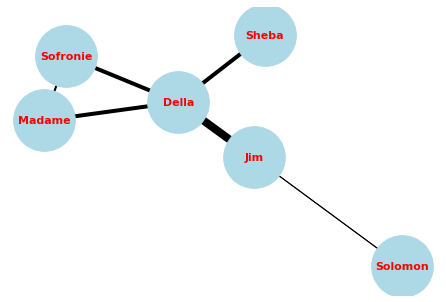

In [20]:
nx.draw(G, pos = positions, node_color = 'lightblue', node_size = 3800)
nx.draw_networkx_labels(
    G,
    pos = positions,
    font_size = 11,
    font_color = 'red',
    font_weight = 'bold'
)

for node1, node2, edge_attr in G.edges(data=True):
        width = edge_attr['weight']
        edgelist = [(node1, node2)]
        nx.draw_networkx_edges(
            G,
            positions,
            edgelist = edgelist,
            width = width
        )

In [21]:
import pandas as pd

In [22]:
data = {
    'Degree': nx.degree_centrality(G),
    'Closeness': nx.closeness_centrality(G),
    'Betweenness': nx.betweenness_centrality(G),
    'Pagerank': nx.pagerank(G)
}

pd.DataFrame(data)

,Degree,Closeness,Betweenness,Pagerank
Della,0.8,0.833333,0.8,0.402731
Jim,0.4,0.625000,0.4,0.199166
Madame,0.4,0.555556,0.0,0.130415
Sheba,0.2,0.500000,0.0,0.093464
Sofronie,0.4,0.555556,0.0,0.130415
Solomon,0.2,0.416667,0.0,0.043810
